In [80]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

In [81]:
def STRAT(start_date, end_date, asset, RSI_buy, RSI_sell, MA, stop, comisiones, impuestos, capital):
    
    # Dataframe de la acción y cálculo de RSI
    def RSIcalc(asset): #names
        df = yf.download(asset,start=start_date, end = end_date)
        df['MA'] = df['Adj Close'].rolling(window=MA).mean()
        df['Price Change'] = df['Adj Close'].pct_change()
        df['Upmove'] = df['Price Change'].apply(lambda x: x if x>0 else 0)
        df['Downmove'] = df['Price Change'].apply(lambda x: abs(x) if x<0 else 0)
        df['Avg Up'] = df["Upmove"].ewm(span=19).mean()
        df['Avg Down'] = df["Downmove"].ewm(span=19).mean()
        df = df.dropna()
        df['RS'] = (df['Avg Up']/df['Avg Down'])
        df['RSI']= df['RS'].apply(lambda x: 100-(100/(x+1)))
        df.loc[(df['Adj Close'] > df['MA']) & (df['RSI']<RSI_buy), 'Buy'] = 'Yes'
        df.loc[(df['Adj Close'] < df['MA']) | (df['RSI']>RSI_buy), 'Buy'] = 'No'
        return df
    
    # Fechas de compra y venta con stop loss
    def getSignals2(df, stop):
        Buying_dates = []
        Selling_dates =[]
    
        # Encontramos instantes en donde se indica la compra del activo, se mete a la lista de fechas
        for i in range(len(df)):
            if "Yes" in df['Buy'].iloc[i]:
                Buying_dates.append(df.iloc[i+1].name)

                # Revisamos los siguientes 10 dias a la compra el mercado
                for j in range(1,21):

                    # la fecha en la que se compro
                    flag = Buying_dates[-1]

                    # la fecha de los siguientes 10 dias
                    check = df.iloc[j].name

                    # valor numerico de la accion en la fecha de compra
                    precio_flag = df.loc[flag]['Open']

                    # valor numerico de los 10 dias
                    precio_check = df.loc[check]['Adj Close']

                    # se revisa el cambio porcentual de la accion (se genera un 'Stop loss')
                    porcentaje = (precio_check - precio_flag)/precio_check

                    if ((df['RSI'].iloc[i + j] > RSI_sell) | (porcentaje < stop)):
                        Selling_dates.append(df.iloc[i+j+1].name)
                        break

                    elif j==20:
                        Selling_dates.append(df.iloc[i+j+1].name)


        return Buying_dates, Selling_dates
    
    # Cálculos de rentabilidad de estrategia + gráficas
    
    # Elegir activo:
    stock = asset

    # Generar dataframe y calcular señales de compra:
    frame = RSIcalc(stock)
    Buy, Sell = getSignals2(frame, -0.1)

    # Calcular retornos de estrategia
    Profits = (frame.loc[Sell].Open.values - frame.loc[Buy].Open.values)/(frame.loc[Buy].Open.values)

    # Delimitar costos de mercado y capital inicial
    Comisiones = comisiones
    Capital = capital

    # Generar dataframe de retornos y utilidades
    dfr = pd.DataFrame()
    dfr['Rendimientos'] = Profits
    dfr['Utilidad'] = dfr['Rendimientos']-Comisiones

    # Generar columna de MONTO e INTERÉS COMPUESTO
    Monto = [Capital]

    for i in range(len(dfr)):
        valor = Monto[-1]*(1+dfr['Utilidad'][i])
        Monto.append(valor)

    # se borra capital inicial de la lista de montos
    del Monto[0]
    dfr['Monto'] = np.round(Monto,3)

    # Graficamos cierre de activo con fechas de compra:
    plt.figure(figsize=(12,5))
    plt.scatter(frame.loc[Buy].index , frame.loc[Buy]['Adj Close'], marker='^',c='g')
    plt.scatter(frame.loc[Sell].index , frame.loc[Sell]['Adj Close'], marker='v',c='r')
    plt.plot(frame['Adj Close'], alpha=0.7)
    plt.xlabel('Fecha')
    plt.ylabel('Cierre ajustado')
    plt.title(str(stock)+ ' Positions:')
    plt.show()

    # Graficamos retorno generado por número de posición:
    plt.bar(dfr.index, dfr.Rendimientos,width=0.6)
    plt.xlabel("Posición")
    plt.ylabel("Rendimientos")
    plt.title("Rendimiento por posición")
    plt.show()

    # Calculamos el número de victorias en la estrategia:
    wins = [i for i in Profits if i > 0]
    avrg_win = np.mean(wins)
    wins = len(wins)/len(Profits)

    loss = [i for i in Profits if i < 0]
    avrg_loss = np.mean(loss)

    # Calculamos utilidad final DESPUÉS DE IMPUESTOS
    Impuestos = impuestos

        # Encontramos monto final
    ultimo = dfr[['Monto']].iloc[-1]

        # Restamos impuestos
    ultimo_asset = ultimo * (1-Impuestos)

        # Lo convertimos en tasa comparado al capital inicial
    utilidad_asset = (ultimo_asset - Capital) / Capital

    # Mandamos todo a proyectar en la misma celda
    return display(dfr, 
            'Victorias: '+str(np.round(wins,3)),
            'Victoria promedio: ' +str(np.round(avrg_win,3)),
            'Perdida promedio: '+str(np.round(avrg_loss,3)),
            'Balance: '+str(np.round(ultimo_asset,3)[0]),
            'Utilidad: ' +str(np.round(utilidad_asset,3)[0]))

[*********************100%***********************]  1 of 1 completed


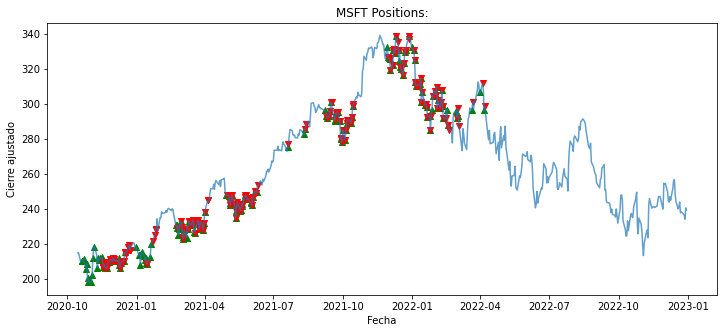

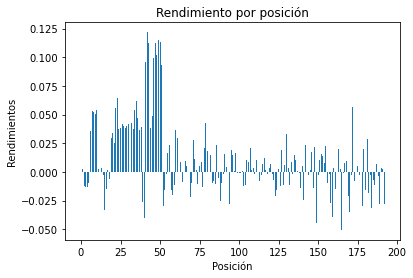

,Rendimientos,Utilidad,Monto
0,0.001390,-0.001110,998890.190
1,0.002487,-0.000013,998877.061
2,-0.011920,-0.014420,984473.523
3,-0.013161,-0.015661,969055.720
4,-0.013561,-0.016061,953491.765
...,...,...,...
188,-0.003509,-0.006009,4368718.821
189,-0.028393,-0.030893,4233755.270
190,0.003045,0.000545,4236060.585
191,0.002327,-0.000173,4235329.078


'Victorias: 0.58'

'Victoria promedio: 0.028'

'Perdida promedio: -0.014'

'Balance: 3695727.748'

'Utilidad: 2.696'

[*********************100%***********************]  1 of 1 completed


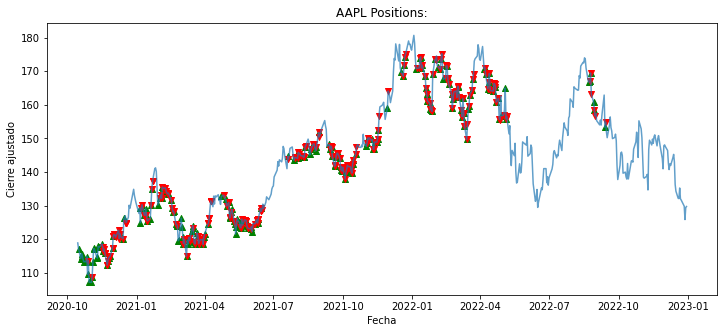

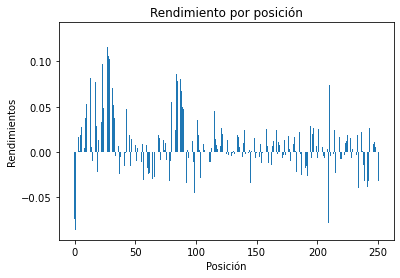

,Rendimientos,Utilidad,Monto
0,-0.073466,-0.075966,924033.673
1,-0.085862,-0.088362,842384.287
2,0.028830,0.026330,864563.977
3,0.016628,0.014128,876778.638
4,0.001192,-0.001308,875631.804
...,...,...,...
246,0.008726,0.006226,3280128.319
247,0.010606,0.008106,3306715.638
248,0.006081,0.003581,3318558.174
249,-0.011226,-0.013726,3273008.957


'Victorias: 0.566'

'Victoria promedio: 0.026'

'Perdida promedio: -0.016'

'Balance: 2844206.389'

'Utilidad: 1.844'

[*********************100%***********************]  1 of 1 completed


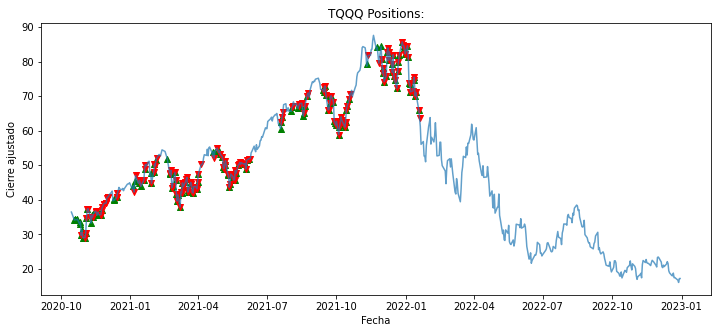

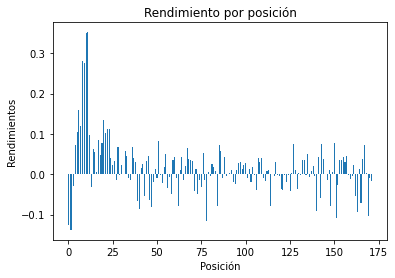

,Rendimientos,Utilidad,Monto
0,-0.125777,-0.128277,871723.210
1,-0.138077,-0.140577,749178.638
2,-0.137393,-0.139893,644373.785
3,-0.029420,-0.031920,623805.251
4,0.073524,0.071024,668110.479
...,...,...,...
167,0.073485,0.070985,6065631.380
168,0.001883,-0.000617,6061891.555
169,-0.104240,-0.106740,5414847.608
170,-0.008684,-0.011184,5354286.311


'Victorias: 0.576'

'Victoria promedio: 0.052'

'Perdida promedio: -0.036'

'Balance: 4727305.555'

'Utilidad: 3.727'

[*********************100%***********************]  1 of 1 completed


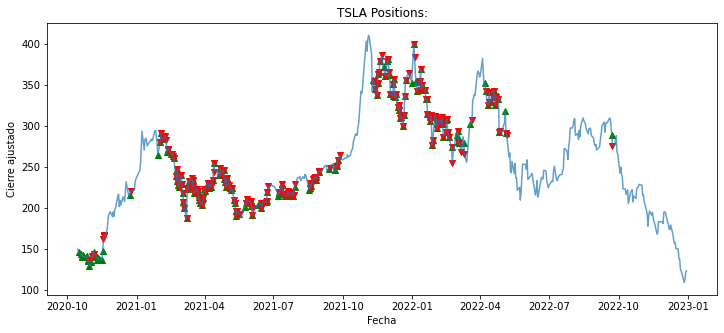

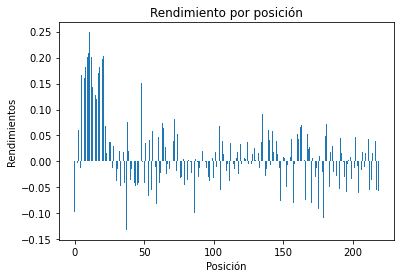

,Rendimientos,Utilidad,Monto
0,-0.097879,-0.100379,899621.332
1,-0.081817,-0.084317,823767.919
2,-0.002617,-0.005117,819552.421
3,0.060681,0.058181,867235.094
4,-0.013170,-0.015670,853645.676
...,...,...,...
214,0.016814,0.014314,8684022.201
215,-0.097295,-0.099795,7817403.569
216,0.038808,0.036308,8101236.855
217,-0.055398,-0.057898,7632190.052


'Victorias: 0.557'

'Victoria promedio: 0.051'

'Perdida promedio: -0.034'

'Balance: 6467644.098'

'Utilidad: 5.468'

In [82]:
tickers = ['MSFT','AAPL','TQQQ','TSLA']
capital = 1000000

for i in tickers:
    STRAT('2020-01-01', '2023-01-01', i, 60, 70, 200, -0.1, 0.0025, 0.1, capital)

In [83]:
# MA200
cap_total = capital*4
suma_montos = 3695727.748 + 2844206.389 + 4727305.555 + 6467644.098
utilidad_total = (suma_montos - cap_total) / cap_total
np.round(utilidad_total,3), suma_montos

(3.434, 17734883.79)

In [84]:
#MA150
cap_total = capital*4
suma_montos = 15449398.055 + 1945690.716 + 9563420.696 + 1639114.316
utilidad_total = (suma_montos - cap_total) / cap_total
np.round(utilidad_total,3), suma_montos

(6.149, 28597623.783)